In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv("toolwindow_data.csv")
df

,timestamp,event,open_type,user_id
0,1752250204033,opened,manual,1
1,1751836141616,closed,NaN,2
2,1752304475081,closed,NaN,3
3,1752498934494,opened,auto,4
4,1752141991110,closed,NaN,5
...,...,...,...,...
3498,1752370291754,closed,NaN,64
3499,1752659734021,opened,auto,43
3500,1752893558172,opened,auto,75
3501,1753022042357,opened,manual,88


In [3]:
# convert timestamps
df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
df['dt'] = pd.to_datetime(df['timestamp'], unit='ms', origin='unix', utc=True)

df

,timestamp,event,open_type,user_id,dt
0,1752250204033,opened,manual,1,2025-07-11 16:10:04.033000+00:00
1,1751836141616,closed,NaN,2,2025-07-06 21:09:01.616000+00:00
2,1752304475081,closed,NaN,3,2025-07-12 07:14:35.081000+00:00
3,1752498934494,opened,auto,4,2025-07-14 13:15:34.494000+00:00
4,1752141991110,closed,NaN,5,2025-07-10 10:06:31.110000+00:00
...,...,...,...,...,...
3498,1752370291754,closed,NaN,64,2025-07-13 01:31:31.754000+00:00
3499,1752659734021,opened,auto,43,2025-07-16 09:55:34.021000+00:00
3500,1752893558172,opened,auto,75,2025-07-19 02:52:38.172000+00:00
3501,1753022042357,opened,manual,88,2025-07-20 14:34:02.357000+00:00


In [4]:
df = df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)
df

,timestamp,event,open_type,user_id,dt
0,1751826102123,opened,auto,1,2025-07-06 18:21:42.123000+00:00
1,1751826746077,closed,NaN,1,2025-07-06 18:32:26.077000+00:00
2,1751841258635,opened,manual,1,2025-07-06 22:34:18.635000+00:00
3,1751849544609,closed,NaN,1,2025-07-07 00:52:24.609000+00:00
4,1751985487772,opened,manual,1,2025-07-08 14:38:07.772000+00:00
...,...,...,...,...,...
3498,1752063311786,opened,auto,202,2025-07-09 12:15:11.786000+00:00
3499,1751993622531,opened,auto,203,2025-07-08 16:53:42.531000+00:00
3500,1751993632485,closed,NaN,203,2025-07-08 16:53:52.485000+00:00
3501,1752107530446,opened,auto,204,2025-07-10 00:32:10.446000+00:00


In [5]:
from typing import Tuple

def clean_and_pair_events(
    df: pd.DataFrame,
    event_column: str = 'event',
    timestamp_column: str = 'timestamp',
    user_column: str = 'user_id'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    # copy original dataframe and store original indices
    df_copy = df.copy().reset_index().rename(columns={'index': 'original_index'})

    def normalize_event(value):
        return str(value).strip().lower() if pd.notna(value) else ''

    df_copy['_normalized_event'] = df_copy[event_column].apply(normalize_event)

    kept_indices = set() # indices to keep in cleaned df
    removed_records = [] # records removed for bad events
    paired_sessions = [] # list of opened-closed episodes

    # sort by user and timestamp for correct pairing
    grouped_users = df_copy.sort_values([user_column, timestamp_column]).groupby(user_column, sort=False)

    for user_id, user_group in grouped_users:
        user_events = list(user_group.to_dict(orient='records'))
        i = 0
        while i < len(user_events):
            current_event = user_events[i]
            event_type = current_event['_normalized_event']
            orig_idx = int(current_event['original_index'])
            open_type_val = '' if pd.isna(current_event.get('open_type', '')) else str(current_event.get('open_type', '')).strip().lower()

            if event_type == 'opened':
                # look ahead for a closed event for the current open event
                j = i + 1
                close_index = None
                while j < len(user_events):
                    next_event_type = user_events[j]['_normalized_event']
                    if next_event_type == 'closed':
                        close_index = j
                        break
                    if next_event_type == 'opened':
                        close_index = None
                        break

                if close_index is not None:
                    # if closed event found right after open
                    open_event = user_events[i]
                    close_event = user_events[close_index]
                    try:
                        duration_seconds = (float(close_event[timestamp_column]) - float(open_event[timestamp_column])) / 1000.0
                    except Exception:
                        duration_seconds = None

                    if duration_seconds is not None and duration_seconds > 0:
                        # only add if neither row is already marked for deletion
                        deleted_indices = [rec['original_index'] for rec in removed_records]
                        if orig_idx not in deleted_indices and int(close_event['original_index']) not in deleted_indices:
                            paired_sessions.append({
                                'user_id': user_id,
                                'open_index': int(open_event['original_index']),
                                'close_index': int(close_event['original_index']),
                                'open_timestamp': open_event[timestamp_column],
                                'close_timestamp': close_event[timestamp_column],
                                'open_type': open_type_val if open_type_val else 'unknown',
                                'duration_seconds': duration_seconds
                            })
                            kept_indices.add(int(open_event['original_index']))
                            kept_indices.add(int(close_event['original_index']))
                    i = close_index + 1
                else:
                    # opened event with no close event found so delete
                    removed_records.append({
                        'original_index': orig_idx,
                        'user_id': user_id,
                        'event': current_event[event_column],
                        'timestamp': current_event[timestamp_column],
                        'reason': 'unmatched_open_no_later_close'
                    })
                    i += 1

            elif event_type == 'closed':
                # no open for the closed event so delete
                removed_records.append({
                    'original_index': orig_idx,
                    'user_id': user_id,
                    'event': current_event[event_column],
                    'timestamp': current_event[timestamp_column],
                    'reason': 'close_with_no_open'
                })
                i += 1
            else:
                # unknown event type
                removed_records.append({
                    'original_index': orig_idx,
                    'user_id': user_id,
                    'event': current_event[event_column],
                    'timestamp': current_event[timestamp_column],
                    'reason': 'unknown_event_type'
                })
                i += 1

    # build final dataframes
    removed_df = pd.DataFrame(removed_records)
    if not removed_df.empty:
        removed_df = removed_df.merge(df.reset_index().rename(columns={'index':'original_index'}), on='original_index', how='left')

    cleaned_df = df.loc[df.index.isin(list(kept_indices))].copy()
    
    if not removed_df.empty:
        cleaned_df = cleaned_df.loc[~cleaned_df.index.isin(removed_df['original_index'])].reset_index(drop=True)
    else:
        cleaned_df = cleaned_df.reset_index(drop=True)

    episodes_df = pd.DataFrame(paired_sessions)

    # remove any rows with null (not for cleaned because every closed event type has open_type null)
    episodes_df = episodes_df.dropna().reset_index(drop=True)
    
    print(f"Original dataframe length: {len(df)}")
    print(f"Cleaned dataframe length: {len(cleaned_df)}")
    print(f"Paired episodes dataframe length: {len(episodes_df)}")

    return episodes_df, cleaned_df, removed_df


episodes_df, cleaned_df, removed_df = clean_and_pair_events(df)
episodes_df

Original dataframe length: 3503
Cleaned dataframe length: 3244
Paired episodes dataframe length: 1622


,user_id,open_index,close_index,open_timestamp,close_timestamp,open_type,duration_seconds
0,1,0,1,1751826102123,1751826746077,auto,643.954
1,1,2,3,1751841258635,1751849544609,manual,8285.974
2,1,4,5,1751985487772,1751986623885,manual,1136.113
3,1,6,7,1752250204033,1752250204781,manual,0.748
4,1,8,9,1752250205587,1752257432775,manual,7227.188
...,...,...,...,...,...,...,...
1617,198,3490,3491,1751794789165,1751794914913,auto,125.748
1618,199,3492,3493,1752207158481,1752207181344,manual,22.863
1619,200,3494,3495,1752502731550,1752502765595,manual,34.045
1620,201,3496,3497,1751853675253,1751853683561,manual,8.308


In [6]:
# calculate all the core statistics
def stats_summary(arr):
    if len(arr) == 0:
        return {'count': 0, 'mean': np.nan, 'median': np.nan, 'std dev': np.nan, 'min': np.nan, 'max': np.nan}
    return {
        'count': len(arr),
        'mean': np.mean(arr),
        'median': np.median(arr),
        'std dev': np.std(arr, ddof=1),
        'min': np.min(arr),
        'max': np.max(arr)
    }

In [7]:
manual = episodes_df[episodes_df['open_type'].str.contains('manual')]['duration_seconds'].values
auto = episodes_df[episodes_df['open_type'].str.contains('auto')]['duration_seconds'].values

manual_stats = stats_summary(manual)
auto_stats = stats_summary(auto)

summary_df = pd.DataFrame([manual_stats, auto_stats], index=['manual', 'auto'])
summary_df = summary_df[['count', 'mean', 'median', 'std dev', 'min', 'max']]  # reorder columns
summary_df.style.format({
    'mean': '{:.3f}',
    'median': '{:.3f}',
    'std dev': '{:.3f}',
    'min': '{:.3f}',
    'max': '{:.3f}'
})

,count,mean,median,std dev,min,max
manual,622,1470.260,12.059,10725.427,0.015,180918.694
auto,1000,6323.446,184.821,28626.913,0.154,409873.748


In [8]:
# remove data below 5 percentile and above 95 percentile 
def remove_lower_percentile_outliers(data: np.ndarray, low, high):
    lower_threshhold = np.percentile(data, low)
    higher_threshhold = np.percentile(data, high)
    filtered = data[(data >= lower_threshhold) & (data <= higher_threshhold)]

    return filtered

manual_filtered = remove_lower_percentile_outliers(manual, low=5, high=95)
auto_filtered = remove_lower_percentile_outliers(auto, low=5, high=95)

print(f"Manual: original={len(manual)}, after removing bottom 5%={len(manual_filtered)}")
print(f"Auto: original={len(auto)}, after removing bottom 5%={len(auto_filtered)}")

Manual: original=622, after removing bottom 5%=559
Auto: original=1000, after removing bottom 5%=900


In [9]:
manual_stats = stats_summary(manual_filtered)
auto_stats = stats_summary(auto_filtered)

summary_df = pd.DataFrame([manual_stats, auto_stats], index=['manual', 'auto'])
summary_df = summary_df[['count', 'mean', 'median', 'std dev', 'min', 'max']]  # reorder columns
summary_df.style.format({
    'mean': '{:.3f}',
    'median': '{:.3f}',
    'std dev': '{:.3f}',
    'min': '{:.3f}',
    'max': '{:.3f}'
})

,count,mean,median,std dev,min,max
manual,559,155.817,12.056,374.380,0.649,2611.076
auto,900,1501.925,184.821,3863.822,5.259,31364.178


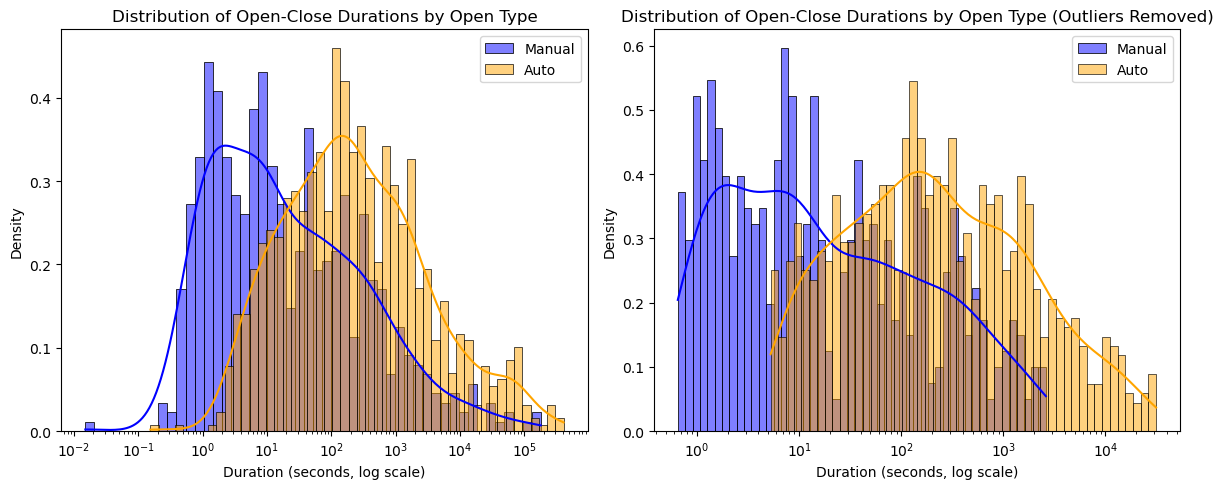

In [10]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(manual, color='blue', label='Manual', kde=True, stat='density', bins=50, log_scale=(True, False))
sns.histplot(auto, color='orange', label='Auto', kde=True, stat='density', bins=50, log_scale=(True, False))
plt.xlabel("Duration (seconds, log scale)")
plt.ylabel("Density")
plt.title("Distribution of Open-Close Durations by Open Type")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(manual_filtered, color='blue', label='Manual', kde=True, stat='density', bins=50, log_scale=(True, False))
sns.histplot(auto_filtered, color='orange', label='Auto', kde=True, stat='density', bins=50, log_scale=(True, False))
plt.xlabel("Duration (seconds, log scale)")
plt.ylabel("Density")
plt.title("Distribution of Open-Close Durations by Open Type (Outliers Removed)")
plt.legend()

plt.tight_layout()
plt.show()

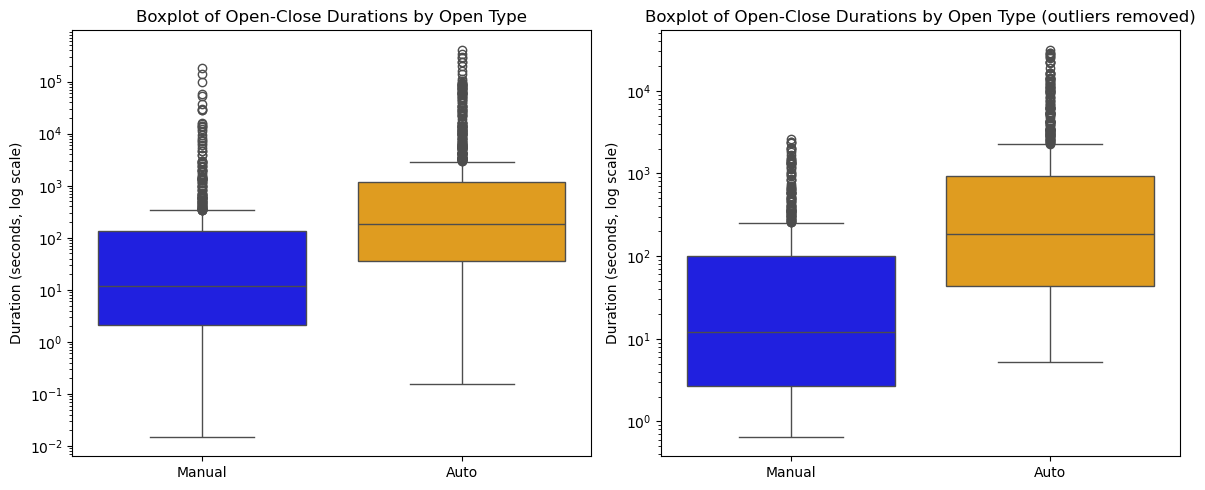

In [11]:
# boxplots of both manual/auto
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.boxplot(data=[manual, auto], palette=['blue','orange'])
plt.xticks([0,1], ['Manual', 'Auto'])
plt.yscale('log')
plt.ylabel("Duration (seconds, log scale)")
plt.title("Boxplot of Open-Close Durations by Open Type")

plt.subplot(1, 2, 2)
sns.boxplot(data=[manual_filtered, auto_filtered], palette=['blue','orange'])
plt.xticks([0,1], ['Manual', 'Auto'])
plt.yscale('log')
plt.ylabel("Duration (seconds, log scale)")
plt.title("Boxplot of Open-Close Durations by Open Type (outliers removed)")

plt.tight_layout()
plt.show()

In [16]:
# function to caluclate summary statistics
def compute_summary(data, label):
    data = data[~np.isnan(data)]
    count = len(data)
    mean_val = np.mean(data)
    median_val = np.median(data)
    max_val = np.max(data) if len(data) else np.nan
    min_val = np.min(data) if len(data) else np.nan
    std_val = np.std(data, ddof=1)
    sem = std_val / np.sqrt(count)
    q1, q3 = np.percentile(data, [25,75])
    iqr = q3 - q1
    
    return {
        'Open Type': label,
        'Count': count,
        'Mean': mean_val,
        'Median': median_val,
        'Minimum': min_val,
        'Maximum': max_val,
        'Std': std_val,
        'Q1': q1,
        'Q3': q3,
        'IQR': iqr,
    }

# calculate summary for manual and auto filtered
manual_summary = compute_summary(manual_filtered, 'Manual Filtered')
auto_summary = compute_summary(auto_filtered, 'Auto Filtered')

# create summary table
summary_df = pd.DataFrame([manual_summary, auto_summary])
pd.set_option('display.float_format', '{:.2f}'.format)
print("Summary Table (outliers removed):")
display(summary_df)

# calculate summary for manual and auto not filtered
manual_summary = compute_summary(manual, 'Manual')
auto_summary = compute_summary(auto, 'Auto')

summary_df = pd.DataFrame([manual_summary, auto_summary])
pd.set_option('display.float_format', '{:.2f}'.format)
print("Summary Table:")
display(summary_df)

Summary Table (outliers removed):


,Open Type,Count,Mean,Median,Minimum,Maximum,Std,Q1,Q3,IQR
0,Manual Filtered,559,155.82,12.06,0.65,2611.08,374.38,2.64,101.46,98.82
1,Auto Filtered,900,1501.92,184.82,5.26,31364.18,3863.82,42.99,937.77,894.78


Summary Table:


,Open Type,Count,Mean,Median,Minimum,Maximum,Std,Q1,Q3,IQR
0,Manual,622,1470.26,12.06,0.01,180918.69,10725.43,2.15,135.66,133.51
1,Auto,1000,6323.45,184.82,0.15,409873.75,28626.91,35.20,1195.74,1160.54


In [39]:
# confidence interval

def compute_confidence(manual_data, auto_data):

    manual_ci = stats.t.interval(
        0.95, len(manual_data) - 1,
        loc=np.mean(manual_data),
        scale=stats.sem(manual_data)
    )
    auto_ci = stats.t.interval(
        0.95, len(auto_data) - 1,
        loc=np.mean(auto_data),
        scale=stats.sem(auto_data)
    )
    
    # t-test
    t_stat, p_val = stats.ttest_ind(manual_data, auto_data, equal_var=False)
    
    # compile all results
    summary_df = pd.DataFrame({
        "Metric": [
            "Manual mean duration",
            "Auto mean duration",
            "Manual 95% CI lower limit",
            "Manual 95% CI upper limit",
            "Auto 95% CI lower limit",
            "Auto 95% CI upper limit",
            "t-statistic",
            "p-value",
        ],
        "Value": [
            np.mean(manual_data),
            np.mean(auto_data),
            manual_ci[0], manual_ci[1],
            auto_ci[0], auto_ci[1],
            t_stat,
            p_val
        ]
    })

    # convert to df and print
    summary_df["Value"] = summary_df["Value"].apply(lambda x: f"{x:,.6g}")
    summary_df.index = np.arange(1, len(summary_df) + 1)

    return summary_df

print('Manual and auto data, unfiltered:')
compute_confidence(manual, auto)

Manual and auto data, unfiltered:


,Metric,Value
1,Manual mean duration,"1,470.26"
2,Auto mean duration,"6,323.45"
3,Manual 95% CI lower limit,625.73
4,Manual 95% CI upper limit,"2,314.79"
5,Auto 95% CI lower limit,"4,547.01"
6,Auto 95% CI upper limit,"8,099.88"
7,t-statistic,-4.84244
8,p-value,1.42631e-06


In [40]:
print('Manual and auto data, outliers removed:')

compute_confidence(manual_filtered, auto_filtered)

Manual and auto data, outliers removed:


,Metric,Value
1,Manual mean duration,155.817
2,Auto mean duration,"1,501.92"
3,Manual 95% CI lower limit,124.714
4,Manual 95% CI upper limit,186.92
5,Auto 95% CI lower limit,"1,249.15"
6,Auto 95% CI upper limit,"1,754.7"
7,t-statistic,-10.3735
8,p-value,6.30246e-24
